## Model Building

Build logistic regression, random forest, and XGBoost models to predict the probability of an upset in the NCAA tournament

Based on data output in M1_DataCleaning.ipynb, model used in M3_Predictions.py

In [1]:
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
import pickle

In [2]:
# matchup data outputted from M1_DataCleaning.ipynb
matchups = pd.read_csv('mydata/mens/matchups.csv')
matchups.head()

,Season,TeamrankRating_x,TrankRating_x,OE_x,DE_x,Tempo_x,Seed_x,3ptRate_x,Ast%_x,FT%_x,...,xOffyDefFTRateAvg,yOffxDefFTRateAvg,AbsxOffyDefAstDiff,AbsyOffxDefAstDiff,xOffyDefAstAvg,yOffxDefAstAvg,TotalPossVarSum,GameScoreVarSum,TrankNaiveUpsetProbability,TeamrankNaiveUpsetProbability
0,2008.0,28.5,0.960742,117.213494,88.761128,73.7,2,0.390996,0.522826,0.694618,...,0.380141,0.330101,0.011372,0.152258,0.528512,0.552607,342.200873,0.030100,0.011556,0.022079
1,2008.0,28.5,0.960742,117.213494,88.761128,73.7,2,0.390996,0.522826,0.694618,...,0.396759,0.345179,0.004257,0.109056,0.520698,0.531006,295.048054,0.047594,0.312558,0.323143
2,2008.0,23.6,0.927155,115.187217,92.329124,65.8,3,0.371802,0.610714,0.750341,...,0.403042,0.342810,0.092145,0.018604,0.564642,0.594836,269.327900,0.072884,0.459461,0.493502
3,2008.0,32.4,0.981585,120.970641,85.610492,69.5,1,0.291796,0.627572,0.707756,...,0.360666,0.341935,0.079363,0.078373,0.587891,0.574597,266.467752,0.058420,0.030979,0.039768
4,2008.0,32.4,0.981585,120.970641,85.610492,69.5,1,0.291796,0.627572,0.707756,...,0.350930,0.316380,0.080697,0.071639,0.587224,0.571230,309.871774,0.046553,0.084577,0.069552


In [3]:
y = matchups['ScorePerPossDiff']
X = matchups.drop(columns = ['Upset', 'ScorePerPossDiff'])

In [4]:
# read in previous results to not duplicate params that have already been tested
prev_results = pd.read_csv('mydata/mens/training_results_spread.csv')
prev_results.head()

,Type,Num_Features,Features,Model,Model_Coef,2008_Score,2009_Score,2010_Score,2011_Score,2012_Score,2013_Score,2014_Score,2015_Score,2016_Score,2017_Score,2018_Score,2019_Score
0,rf,All,All,"RandomForestRegressor(max_features=26, min_sam...","{'max_features': 26, 'max_depth': None, 'min_s...",0.036087,0.030588,0.027593,0.036160,0.021032,0.043503,0.030992,0.023487,0.035227,0.027618,0.032460,0.032098
1,rf,All,All,"RandomForestRegressor(max_features=30, min_sam...","{'max_features': 30, 'max_depth': None, 'min_s...",0.034537,0.029874,0.026415,0.034842,0.021782,0.043381,0.032298,0.023499,0.033808,0.026079,0.034656,0.033101
2,rf,All,All,"RandomForestRegressor(max_depth=20, max_featur...","{'max_features': 28, 'max_depth': 20, 'min_sam...",0.034165,0.030089,0.026526,0.034218,0.021494,0.043172,0.032083,0.023230,0.034228,0.025750,0.034560,0.033075
3,rf,All,All,"RandomForestRegressor(max_depth=20, max_featur...","{'max_features': 30, 'max_depth': 20, 'min_sam...",0.036128,0.030680,0.027804,0.036257,0.021156,0.043208,0.030860,0.023331,0.035110,0.027765,0.032487,0.032211
4,rf,All,All,"RandomForestRegressor(max_features=26, min_sam...","{'max_features': 26, 'max_depth': None, 'min_s...",0.039553,0.032409,0.027401,0.039097,0.023398,0.045343,0.032957,0.025358,0.037614,0.031062,0.032193,0.033994


### Linear Regression

In [5]:
# lasso regularization for feature selection
# coefficients range from 0.000001 to 0.1
# each coefficient is 12.2% larger than last, there are 100 coefficients in total
lasso_reg = [1e-6 * (1.122) ** i for i in range(100)]

# ridge regularization to prevent overfitting
ridge_reg = [1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 1e0, 3e0, 1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7]

# scale used to scale columns before applying regularization
scale = StandardScaler()

def train_linear_regression():
    
    # list/dictionaries to store results
    feature_list = []
    scores = {}
    model_coefs = []
    models = []
    num_features = []
    
    # for each possible lasso regularization coefficient
    for c in tqdm(lasso_reg):
        
        # dont use season as a feature
        X_lasso = X.drop(columns = ['Season'])
        
        # scale columns before regularization
        X_lasso = pd.DataFrame(scale.fit_transform(X_lasso), columns = X_lasso.columns)
        
        # fit L1 logistic regression for feature selection
        lasso = Lasso(alpha = c, random_state = 0, max_iter = 10000).fit(X_lasso, y)
        
        # filter for the columns with nonzero coefficients and the season column
        zero_cols = []
        for i in range(len(lasso.coef_)):
            if lasso.coef_[i] == 0.0:
                zero_cols.append(X_lasso.columns[i])
        nonzero_X = X.drop(columns = zero_cols)
        
        # if there is at least 1 nonzero column and the same amount of features hasn't already been built
        if (len(nonzero_X.columns) > 1 and (len(nonzero_X.columns) - 1) not in num_features):
            
            # try each L2 regularization coefficient
            for c2 in ridge_reg:
                
                # cross validate over each season
                for season in list(X['Season'].unique()):
                    
                    # add season to scores dictionary
                    if season not in scores:
                        scores[season] = []
                        
                    # split into train and validation sets
                    X_train = nonzero_X[nonzero_X['Season'] != season].drop(columns = ['Season'])
                    X_val = nonzero_X[nonzero_X['Season'] == season].drop(columns = ['Season'])
                    X_train = pd.DataFrame(scale.fit_transform(X_train), columns = X_train.columns)
                    X_val = pd.DataFrame(scale.transform(X_val), columns = X_val.columns)
                    y_train = y[X_train.index]
                    y_val = y[X_val.index]
                    
                    # fit logistic regression
                    lin_model = Ridge(alpha = c2, max_iter = 10000, random_state = 0).fit(X_train, y_train)
                    
                    # predict win probabilities
                    predictions = lin_model.predict(X_val)
                    
                    # calculate log loss and store
                    val_score = mean_squared_error(y_val, predictions)
                    scores[season].append(val_score)
                    
                # retrain model on full dataset for coefficients
                lin_model = Ridge(alpha = c2, max_iter = 10000, random_state = 0).fit(pd.DataFrame(scale.fit_transform(nonzero_X), columns = nonzero_X.columns).drop(columns = ['Season']), y)
                
                # store model details
                feature_list.append(nonzero_X.drop(columns = ['Season']).columns)
                num_features.append(len(nonzero_X.drop(columns = ['Season']).columns))
                models.append(lin_model)
                model_coefs.append({'lasso_coef': c, 'ridge_coef': c2})
                
    # return dataframe of results
    return pd.DataFrame({'Type': ['log' for i in range(len(models))],
                         'Num_Features': num_features,
                         'Features': feature_list,
                         'Model': models,
                         'Model_Coef': model_coefs,
                         '2008_Score': scores[2008],
                         '2009_Score': scores[2009],
                         '2010_Score': scores[2010],
                         '2011_Score': scores[2011],
                         '2012_Score': scores[2012],
                         '2013_Score': scores[2013],
                         '2014_Score': scores[2014],
                         '2015_Score': scores[2015],
                         '2016_Score': scores[2016],
                         '2017_Score': scores[2017],
                         '2018_Score': scores[2018],
                         '2019_Score': scores[2019]})

### Random Forest

In [6]:
# random forest paramaters
max_features_list = [27, 28, 29, 30, 31, 32, 33]
rf_max_depths = [1, 2, 3, 4]
min_samples = [0.001, 0.003, 0.01]

def train_random_forest():
    
    # list/dictionaries to store results
    scores = {}
    models = []
    model_coefs = []
    
    # fit 100 models
    for i in tqdm(range(1)):
        
        # randomly generate random forest params
        rf_params = {'max_features': max_features_list[random.randint(0, len(max_features_list) - 1)],
                     'max_depth': rf_max_depths[random.randint(0, len(rf_max_depths) - 1)],
                     'min_samples_leaf': min_samples[random.randint(0, len(min_samples) - 1)]
                    }
        
        # keep generating params if they've already been tested
        while rf_params in list(prev_results['Model_Coef']):
            rf_params = {'max_features': max_features_list[random.randint(0, len(max_features_list) - 1)],
                         'max_depth': rf_max_depths[random.randint(0, len(rf_max_depths) - 1)],
                         'min_samples_leaf': min_samples[random.randint(0, len(min_samples) - 1)]
                        }
        
        # cross validate over each season
        for season in list(X['Season'].unique()):
            
            # add season to scores dictionary
            if season not in scores:
                scores[season] = []
            
            # split into train and validation sets
            X_train = X[X['Season'] != season].drop(columns = ['Season'])
            X_val = X[X['Season'] == season].drop(columns = ['Season'])
            y_train = y[X_train.index]
            y_val = y[X_val.index]
            
            # fit random forest model
            rf_model = RandomForestRegressor(n_estimators = 500,
                                             max_depth = rf_params['max_depth'],
                                             min_samples_leaf = rf_params['min_samples_leaf'],
                                             max_features = rf_params['max_features'],
                                             random_state = 0).fit(X_train, y_train)
            
            # predict win probabilities
            predictions = rf_model.predict(X_val)
            
            # calculate log loss and store score
            val_score = mean_squared_error(y_val, predictions)
            scores[season].append(val_score)
            
        # retrain model on full dataset for feature importances
        rf_model = RandomForestRegressor(n_estimators = 500,
                                         max_depth = rf_params['max_depth'],
                                         min_samples_leaf = rf_params['min_samples_leaf'],
                                         max_features = rf_params['max_features'],
                                         random_state = 0).fit(X.drop(columns = ['Season']), y)
        
        # store model details
        model_coefs.append(rf_params)
        models.append(rf_model)
        
    # return dataframe of results
    return pd.DataFrame({'Type': ['rf' for i in range(len(models))],
                         'Num_Features': ['All' for i in range(len(models))],
                         'Features': ['All' for i in range(len(models))],
                         'Model': models,
                         'Model_Coef': model_coefs,
                         '2008_Score': scores[2008],
                         '2009_Score': scores[2009],
                         '2010_Score': scores[2010],
                         '2011_Score': scores[2011],
                         '2012_Score': scores[2012],
                         '2013_Score': scores[2013],
                         '2014_Score': scores[2014],
                         '2015_Score': scores[2015],
                         '2016_Score': scores[2016],
                         '2017_Score': scores[2017],
                         '2018_Score': scores[2018],
                         '2019_Score': scores[2019]})

### XGBoost

In [7]:
# XGBoost parameters
etas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
xgb_max_depths = [9, 10, 11, 12, 13, 14]
min_child_weights = [6]
gammas = [0.3]
subsamples = [1]
lambdas = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]

def train_xgboost():
    
    # list/dictionaries to store results
    scores = {}
    models = []
    model_coefs = []
    
    # fit 100 models
    for i in tqdm(range(50)):
        
        # randomly generate XGBoost params
        xgb_params = {'eta': etas[random.randint(0, len(etas) - 1)],
                      'max_depth': xgb_max_depths[random.randint(0, len(xgb_max_depths) - 1)],
                      'min_child_weight': min_child_weights[random.randint(0, len(min_child_weights) - 1)],
                      'gamma': gammas[random.randint(0, len(gammas) - 1)],
                      'subsample': subsamples[random.randint(0, len(subsamples) - 1)],
                      'lambda': lambdas[random.randint(0, len(lambdas) - 1)],
                      'random_state': 0
                     }
        # keep randomly generating if params have already been tested
        while xgb_params in list(prev_results['Model_Coef']):
            # randomly generate XGBoost params
            xgb_params = {'eta': etas[random.randint(0, len(etas) - 1)],
                          'max_depth': xgb_max_depths[random.randint(0, len(xgb_max_depths) - 1)],
                          'min_child_weight': min_child_weights[random.randint(0, len(min_child_weights) - 1)],
                          'gamma': gammas[random.randint(0, len(gammas) - 1)],
                          'subsample': subsamples[random.randint(0, len(subsamples) - 1)],
                          'lambda': lambdas[random.randint(0, len(lambdas) - 1)],
                          'random_state': 0
                         }
        
        # cross validate over each season
        for season in list(X['Season'].unique()):
            
            # add season to scores dictionary
            if season not in scores:
                scores[season] = []
                
            # split into train and validation sets
            X_train = X[X['Season'] != season].drop(columns = ['Season'])
            X_val = X[X['Season'] == season].drop(columns = ['Season'])
            y_train = y[X_train.index]
            y_val = y[X_val.index]
            
            # fit XGBoost model
            xgb_model = XGBRegressor(**xgb_params).fit(X_train, y_train)
            
            # predict win probabilities
            predictions = xgb_model.predict(X_val)
            
            # calculate log loss and store score
            val_score = mean_squared_error(y_val, predictions)
            scores[season].append(val_score)
            
        # retrain model on full dataset for feature importances
        xgb_model = XGBRegressor(**xgb_params).fit(X.drop(columns = ['Season']), y)
        
        # store model details
        model_coefs.append(xgb_params)
        models.append(xgb_model)
        
    # return dataframe of results
    return pd.DataFrame({'Type': ['xgb' for i in range(len(models))],
                         'Num_Features': ['All' for i in range(len(models))],
                         'Features': ['All' for i in range(len(models))],
                         'Model': models,
                         'Model_Coef': model_coefs,
                         '2008_Score': scores[2008],
                         '2009_Score': scores[2009],
                         '2010_Score': scores[2010],
                         '2011_Score': scores[2011],
                         '2012_Score': scores[2012],
                         '2013_Score': scores[2013],
                         '2014_Score': scores[2014],
                         '2015_Score': scores[2015],
                         '2016_Score': scores[2016],
                         '2017_Score': scores[2017],
                         '2018_Score': scores[2018],
                         '2019_Score': scores[2019]})

### Results

In [8]:
# train the models
#lm_results = train_linear_regression()
rf_results = train_random_forest()
xgb_results = train_xgboost()
final_results = pd.concat([prev_results, rf_results, xgb_results], ignore_index = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [16:05<00:00, 19.31s/it]


In [9]:
# calculate percentiles of scores in relation to other models
score_cols = []
for col in final_results.columns:
    if col.endswith("Score"):
        score_cols.append(col)

# calculate average score and average percentile
final_results['Avg_Score'] = final_results[score_cols].mean(axis = 1)

In [10]:
# function to show feature importances of given model by results row index
def features(row_index):
    model = final_results.loc[row_index, 'Model']
    
    # if model is logistic regression, return coefficients
    if final_results.loc[row_index, 'Type'] == 'log':
        model_features = list(final_results.loc[row_index, 'Features'])
        sign_list = []
        coef_list = []
        for i in range(len(model_features)):
            coef = round(model.coef_[i], 6)
            coef_list.append(coef)
            if coef > 0:
                sign_list.append('+')
            else:
                sign_list.append('-')
        
        return_df =  pd.DataFrame({'Feature': model_features,
                             'Sign': sign_list,
                            'Coefficient': coef_list})
        return return_df.reindex(return_df['Coefficient'].abs().sort_values(ascending = False).index)
        
    # if model is random forest or XGBoost, return feature importance plot
    else:
        feat_importances = pd.Series(model.feature_importances_, index = X.drop(columns = ['Season']).columns)
        return feat_importances.nlargest(15).plot(kind = 'barh')

In [11]:
# function to show params of given model by results row index
def params(row_index):
    return final_results.loc[row_index, 'Model_Coef']

In [12]:
# print results
pd.set_option('display.max_rows', 50)
final_results[['Type', 'Avg_Score']].sort_values(by = ['Avg_Score'], ascending = True).head(50)

,Type,Avg_Score
770,rf,0.030644
720,xgb,0.030783
781,xgb,0.030783
809,xgb,0.030783
808,xgb,0.030783
782,xgb,0.030783
783,xgb,0.030783
805,xgb,0.030783
785,xgb,0.030783
787,xgb,0.030783


In [21]:
for i in [781, 794]:
    print(params(i))

{'max_features': 33, 'max_depth': 2, 'min_samples_leaf': 0.01}
{'max_features': 33, 'max_depth': 2, 'min_samples_leaf': 0.003}


<AxesSubplot:>

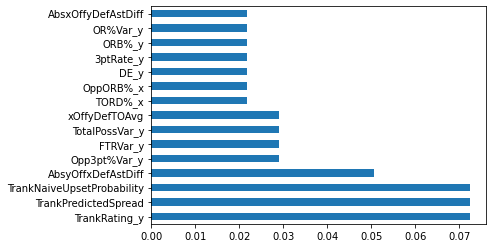

In [15]:
features(809)

In [13]:
final_results.loc[809, 'Model']

XGBRegressor(eta=0.03, gamma=0.3, lambda=30, max_depth=11, min_child_weight=6)

In [24]:
final_results[['Type', 'Num_Features', 'Features', 'Model', 'Model_Coef', '2008_Score',
               '2009_Score', '2010_Score', '2011_Score', '2012_Score', '2013_Score',
               '2014_Score', '2015_Score', '2016_Score', '2017_Score', '2018_Score',
               '2019_Score']].to_csv('mydata/training_results_spread.csv', index = False)

In [25]:
pickle.dump(final_results.loc[781, 'Model'], open('models/MSpreadRF.sav', 'wb'))

In [14]:
pickle.dump(final_results.loc[809, 'Model'], open('models/MSpreadXGB.sav', 'wb'))